# QOSF Screening Task 1

###### Prepared by: Tharrmashastha SAPV

In this notebook, we aim to prepare a quantum state as close as possible to some randomly generated 4 qubit quantum state using the odd and even blocks as defined as below:

Odd Block:
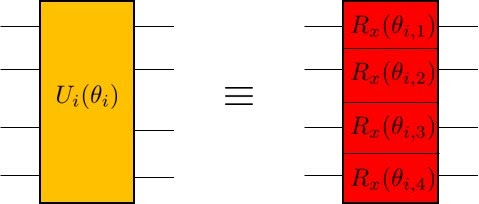

Even Block:
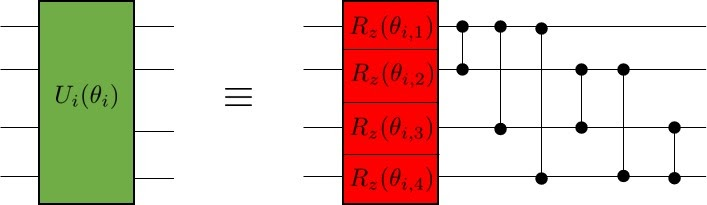

We apply layers of the odd-even blocks and use optimization of angle parameter to reach the target state. 

We first import the necessary packages.

In [139]:
from qiskit import *
from qiskit.circuit.library import *
from qiskit.aqua.components.optimizers import *
import numpy as np
from math import pi, sqrt
import matplotlib.pyplot as plt

We now create a function that creates the quantum circuit corresponding to the odd and the even blocks.

In [206]:
def U1(theta):
    '''Creates a quantum circuit for the odd block.'''
    U1_circ = QuantumCircuit(4, name='U1')
    for i in range(4):
        U1_circ.append(RXGate(theta[i]),[i])
    return U1_circ

def U2(theta):
    '''Creates a quantum circuit for the even block.'''
    U2_circ = QuantumCircuit(4, name='U2')
    for i in range(4):
        U2_circ.append(RZGate(theta[i]),[i])
    for j in range(3):
        for k in range(j+1,4):
            U2_circ.cz(j,k)
    return U2_circ

Next, we define a function that creates a quantum circuit with layers of odd-even blocks. The parameters for the gates in the blocks are given as the list *theta*.

In [113]:
def base_circuit(layers, theta):
    '''Creates a quantum circuit with alternating odd and even blocks.
    
    Args:
        layers: number of layers of the odd U1 and the even U2 blocks in the circuit.
        
        theta: list of angles for all the odd and even blocks in sequence in the circuit.
                The list should be provided such that the ith four elements of the list
                are the parameters to the ith block in the circuit.
                
                For example:
                
                * If the list [0,0.1,0.2,0.3,0.4,0.5,0.6,0,7] is passed as theta
                    then [0,0.1,0.2,0.3] are the parameters for the U1 block and
                    [0.4,0.5,0.6,0.7] are the parameter for the U2 block.
    '''
    
    circ = QuantumCircuit(4,4)
    for i in range(layers):
        circ.append(U1(theta[8*i:(8*i)+4]),range(4))
        circ.append(U2(theta[(8*i)+4:8*(i+1)]),range(4))
    return circ

Next we define function *target()* that outputs the statevector of some random 4 qubit state. We also define the function *obs_sv* that takes as input a quantum circuit *circ* and returns the statevector of the state obtained as a result of implementing the circuit *circ*.

In [207]:
def target():
    '''Returns a list containing a random statevector.
    '''
    targ = np.random.rand(2**4)+(np.random.rand(2**4)*1j)
    targ_sum = 0
    for i in range(len(targ)):
        targ_sum += np.abs(targ[i])**2
    targ /= sqrt(targ_sum)
    return targ


def obs_sv(circ):
    ''' Returns the state vector that is a result of running the circuit circ on the input
        state |0^n>.
        
        Args:
            circ: the circuit that needs to be implemented on the input state |0^n>.
    '''
    
    return execute(circ,backend=Aer.get_backend('statevector_simulator')).result().get_statevector()

Below we define the cost function that given two statevectors *obs* and *tar*, outputs the L2-distance between *obs* and *tar*. 

In [208]:
def cost(obs, tar):
    '''Returns the distance given by the norm || |psi_obs> - |psi_tar> ||.
    
        Args:
            obs: the statevector of the state |psi_obs>.
            
            tar: the statevector of the state |psi_tar>. 
    '''
    
    cst = 0
    for i in range(len(tar)):
        cst += np.abs(obs[i]-tar[i])**2
    return sqrt(cst)

Now, we define a function *run_optimizer* that iterates over all possible number of layers from 0 to 20 and in each of the iteration, we try to optimize the theta parameters using COBYLA optimizer and try to reach as close as possible to the target state using the circuit created using the base_circuit function. The *run_optimizer* returns a list of the minimum distance between the created state and the target state obtained at each number-of-layers iteration.

Apart from COBYLA, we also tried a few more optimizers like Conjugate Gradient optimizer and Gaussian-smoothed line search for optimizing the angles. However, the performance of those optimizers we very poor compared to COBYLA.

In [209]:
def run_optimizer(n):
    '''Returns a list of the distances where the ith element of the list
        corresponds to the distance between the state reached by optimizing
        the parameters of the quantum circuit created using i layers of 
        odd-even blocks and the randomly generated target state.
        
        Args:
            n: the max number of layers upto which the iteration is performed
    '''
    
    # Create an instance of COBYLA optimizer class.
    optimizer = COBYLA(maxiter=2000, tol=0.0001)
    error = []
    
    # Generate a random statevector corresponding
    # to some random 4 qubit state.
    tar_dist = target()

    # 
    for i in range(n):
        print(i)
        def obj_fn(theta):
            '''Creates a quantum circuit with i layers with each
                layer containing an odd and an even block and 
                runs the circuit in the statevector simulator.
                Returns the distance between the observed statevector
                and the statevector in tar_dist where the distance norm
                is min{ || |psi_obs> - |psi_tar> ||} where the minimum
                is over theta, |psi_obs> is the last created state and
                |psi_tar> is the state that was randomly generated.
                
                Args:
                    theta: a list of parameters that is passed to
                            the base_circuit function.
            '''
            circ = base_circuit(i,theta)
            obs_dist = obs_sv(circ)
            cst = cost(obs_dist,tar_dist)
            return cst

        # Obtain a random set of initial thetas.
        theta = np.random.uniform(0,2*pi,8*i)
        
        # Creating the bounds for the thetas.
        bounds = [(0, 2*pi)]*(8*i)

        # Running the optimizer, obtaining the optimial angles and
        # using them to obtain the current distance between the last created
        # state and the target state.
        ret = optimizer.optimize(num_vars=8*i, objective_function = obj_fn, variable_bounds=bounds, initial_point = theta)
        error.append(obj_fn(ret[0]))
    
    return error

We next create the plot of the minimum distance againt the number of layers. It is quite noticeable that the minimum distance reduces with the increase in the number of layers and then converges after a certain number of layers.

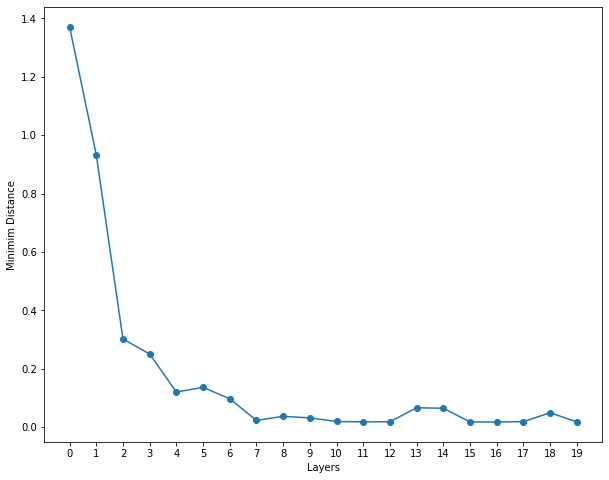

In [161]:
err_std = run_optimizer(20)

# Creating a plot of the minimum distance against the number of layers.
x = [i for i in range(20)]

plt.figure(figsize=(10, 8))
plt.xticks(x)
plt.plot(x, err_std, marker='o')
plt.xlabel('Layers')
plt.ylabel('Minimim Distance')
plt.show()

We now try to create the odd and even blocks using other parameterized gates. First, we perform RY rotations instead of RX rotations in the odd block

In [198]:
def U1(theta):
    '''Creates a quantum circuit for the odd block.'''
    U1_circ = QuantumCircuit(4, name='U1')
    for i in range(4):
        U1_circ.append(RYGate(theta[i]),[i])
    return U1_circ

def U2(theta):
    '''Creates a quantum circuit for the even block.'''
    U2_circ = QuantumCircuit(4, name='U2')
    for i in range(4):
        U2_circ.append(RZGate(theta[i]),[i])
    for j in range(3):
        for k in range(j+1,4):
            U2_circ.cz(j,k)
    return U2_circ

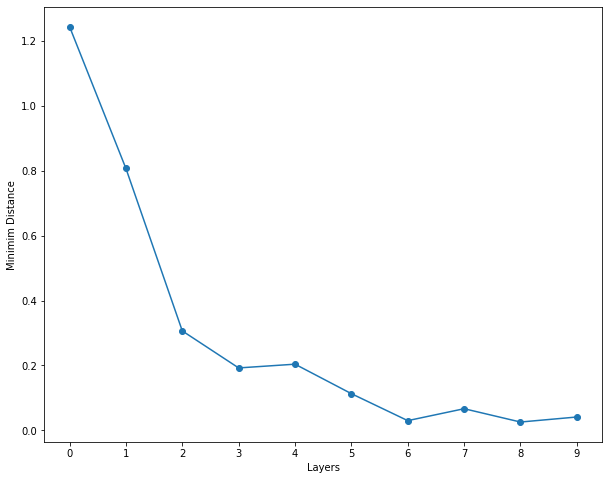

In [200]:
# Obtaining the distance list for the odd-even blocks defined in the above cell.
err_1 = run_optimizer(10)

# Creating a plot of the minimum distance against the number of layers.
x = [i for i in range(10)]

plt.figure(figsize=(10, 8))
plt.xticks(x)
plt.plot(x, err_1, marker='o')
plt.xlabel('Layers')
plt.ylabel('Minimim Distance')
plt.show()

Next, we perform RY rotations instead of RZ rotations in the even block and leave the odd block undisturbed.

In [193]:
def U1(theta):
    '''Creates a quantum circuit for the odd block.'''
    U1_circ = QuantumCircuit(4, name='U1')
    for i in range(4):
        U1_circ.append(RXGate(theta[i]),[i])
    return U1_circ

def U2(theta):
    '''Creates a quantum circuit for the even block.'''
    U2_circ = QuantumCircuit(4, name='U2')
    for i in range(4):
        U2_circ.append(RYGate(theta[i]),[i])
    for j in range(3):
        for k in range(j+1,4):
            U2_circ.cz(j,k)
    return U2_circ

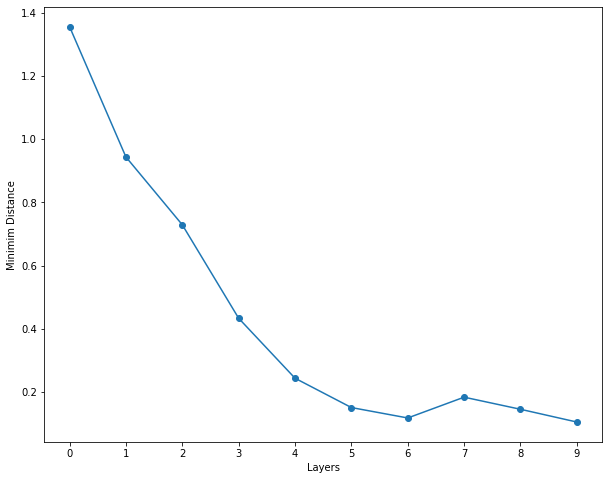

In [195]:
# Obtaining the distance list for the odd-even blocks defined in the above cell.
err_2 = run_optimizer(10)

# Creating a plot of the minimum distance against the number of layers.
x = [i for i in range(10)]

plt.figure(figsize=(10, 8))
plt.xticks(x)
plt.plot(x, err_2, marker='o')
plt.xlabel('Layers')
plt.ylabel('Minimim Distance')
plt.show()

As the last variation, we replace the rotation gates in both the blocks by RY rotations and the controlled-Z gates by the controlled-X gates.

In [189]:
def U1(theta):
    '''Creates a quantum circuit for the odd block.'''
    U1_circ = QuantumCircuit(4, name='U1')
    for i in range(4):
        U1_circ.append(RYGate(theta[i]),[i])
    return U1_circ

def U2(theta):
    '''Creates a quantum circuit for the even block.'''
    U2_circ = QuantumCircuit(4, name='U2')
    for i in range(4):
        U2_circ.append(RYGate(theta[i]),[i])
    for j in range(3):
        for k in range(j+1,4):
            U2_circ.cx(j,k)
    return U2_circ

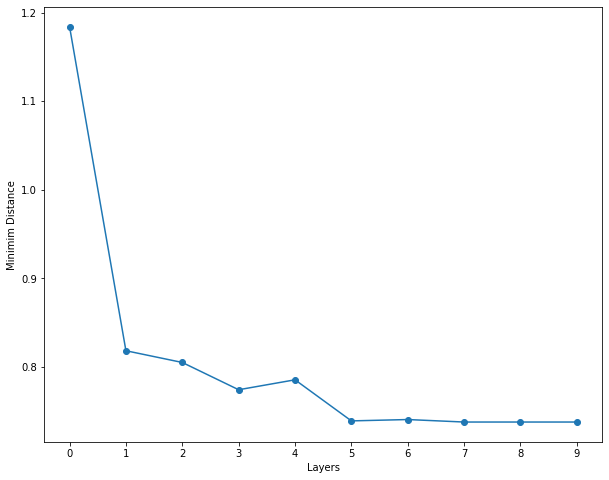

In [192]:
# Obtaining the distance list for the odd-even blocks defined in the above cell.
err_3 = run_optimizer(10)

# Creating a plot of the minimum distance against the number of layers.
x = [i for i in range(10)]

plt.figure(figsize=(10, 8))
plt.xticks(x)
plt.plot(x, err_3, marker='o')
plt.xlabel('Layers')
plt.ylabel('Minimim Distance')
plt.show()

Notice that the performance of the last three variations of the blocks is worse than the first odd and even blocks in approximating the target state.